<style>
    div {
        border: 1px solid gray;
        padding: 8px;
    }

    h1 {
        text-align: center;
        text-transform: uppercase;
        color: #4CAF50;
    }

    p {
        text-indent: 50px;
        text-align: justify;
        letter-spacing: 3px;
    }

    a {
        text-decoration: none;
        color: #008CBA;
    }
</style>

## Legend
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [45]:
import pandas as pd
import numpy as np
import plotly.express as px

import seaborn as sb
import matplotlib.pyplot as plt
from scipy import stats as st

In [46]:
#pd.options.plotting.backend = "plotly"

In [47]:
try:
    games_ori = pd.read_csv('../../dt/tmp/games.csv')
except:
    games_ori = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [48]:
games_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


## Вывод сттистики по пустым значениям

In [49]:

# 3 поля с пропусками >= 40%
games_ori.isna().agg(['sum', 'mean']).T.sort_values(by='sum', ascending=False).style.background_gradient()

,sum,mean
Critic_Score,8578.000000,0.513192
Rating,6766.000000,0.404786
User_Score,6701.000000,0.400897
Year_of_Release,269.000000,0.016093
Name,2.000000,0.000120
Genre,2.000000,0.000120
Platform,0.000000,0.000000
NA_sales,0.000000,0.000000
EU_sales,0.000000,0.000000
JP_sales,0.000000,0.000000


## Приведем столбцы к строчному формату

In [50]:
#games_ori.columns = games_ori.columns.str.strip().str.lower()

games_ori = games_ori.rename(columns=str.lower)

In [51]:
games_ori.sample(5).style.background_gradient(subset=['critic_score'])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
10118,Transformer: Rise of the Dark Spark,XOne,2014.000000,Action,0.070000,0.030000,0.000000,0.010000,nan,nan,nan
12556,Top Gear Hyper-Bike,N64,1999.000000,Racing,0.050000,0.010000,0.000000,0.000000,nan,nan,nan
1224,Dishonored,PS3,2012.000000,Action,0.720000,0.520000,0.040000,0.250000,89.000000,7.9,M
2577,The Sims 2: Pets,PSP,2006.000000,Simulation,0.190000,0.380000,0.000000,0.220000,57.000000,7.3,T
4171,Epic Mickey 2: The Power of Two,PS3,2012.000000,Action,0.210000,0.180000,0.000000,0.080000,59.000000,4.3,E


## Поиск дублей

In [52]:
len(games_ori['name'].str.lower()) - len(games_ori['name'].str.lower().unique())

5155

In [53]:
# Оказалось это не дубли, а разные платформы и релизы
games_ori.query('name.str.lower() == "need for speed: most wanted"').sort_values(by='year_of_release')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
3581,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6410,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E
6473,Need for Speed: Most Wanted,GBA,2005.0,Racing,0.19,0.07,0.00,0.00,NaN,8.3,E
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
2048,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN


In [54]:
games_ori['name'].str.lower().value_counts()

need for speed: most wanted                         12
ratatouille                                          9
lego marvel super heroes                             9
fifa 14                                              9
madden nfl 07                                        9
                                                    ..
jewels of the tropical lost island                   1
sherlock holmes and the mystery of osborne house     1
the king of fighters '95 (cd)                        1
megamind: mega team unite                            1
haitaka no psychedelica                              1
Name: name, Length: 11559, dtype: int64

In [55]:
# Явных дубликатов нет
games_ori.duplicated().sum()

0

## Удаление пустых значений

In [56]:
# Разделим на два датасета:
# датасет, в котором надо будет дополнительно восстанавливать дату релиза, если будет на это время 269 строк
# так как не факт, что на разных платформах игры вышли в один год
to_restore = games_ori.query('year_of_release.isna()')

In [57]:
# второй датасет будет рабочий

good_data = games_ori.query('~year_of_release.isna()')

In [58]:
# 2 пустые строкиб Старый год 1993, ключевые столбцы пропущены, тяжело для восстановления, лучше удалить
games_ori.query('name.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [59]:
good_data = good_data.query('~name.isna()')

In [60]:
# Заодно избавились от пустых значений в столбце жанр
good_data.query('genre.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


###  User_Score — оценка пользователей (максимум 10)

In [61]:
good_data[['name', 'platform', 'year_of_release', 'user_score']].value_counts()
# tbd for To Be Determined, means not enough votes 
# столбец должен быть типа float, поэтому tbd условно заменим на -1
# Пропуски по оценкам либо изначально не были найдены для некоторых записей, либо не записались при формировании базы данных.
# На оценку могут влиять как год, как платформа, так и жанр. Средним значением заменять не будем и высчитывать оэфициенты для игр тоже не будем.
# Также заменим на -1

name                                       platform  year_of_release  user_score
Madden NFL 13                              PS3       2012.0           5.5           2
R.U.S.E.                                   X360      2010.0           7             1
R: Racing Evolution                        GC        2003.0           tbd           1
                                           PS2       2003.0           6.2           1
                                           XB        2003.0           tbd           1
                                                                                   ..
Greg Hastings' Tournament Paintball Max'd  GBA       2006.0           tbd           1
                                           PS2       2006.0           9.2           1
Gretzky NHL                                PSP       2005.0           7.4           1
Gretzky NHL 06                             PS2       2005.0           tbd           1
uDraw Studio: Instant Artist               X360      2011.0

In [62]:
good_data.query('name == "Madden NFL 13"')
# Есть одна интерсная запись, толи дубль, толи опечатка: строка 604 и 16230

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
507,Madden NFL 13,X360,2012.0,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
3986,Madden NFL 13,Wii,2012.0,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E
5887,Madden NFL 13,PSV,2012.0,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
7066,Madden NFL 13,WiiU,2012.0,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


In [63]:
good_data[['name', 'platform', 'year_of_release']].duplicated().sum()
# И она одна единственная

1

In [64]:
# Заменим tbd на -1
#good_data['user_score'] = good_data['user_score'].str.replace('tbd', '-1')
good_data['user_score'] = good_data['user_score'].replace('tbd', np.nan)

In [65]:
# Заменим nan на -1
#good_data['user_score'] = good_data['user_score'].fillna(-1)

In [66]:
# Преобразуем тип данных из object в float
good_data['user_score'] = good_data['user_score'].astype('float')

In [67]:
# Проверим, что пустых значений не осталось
good_data['user_score'].isna().sum()

8981

### Critic_Score — оценка критиков (максимум 100)

In [68]:
good_data[['name', 'platform', 'year_of_release', 'critic_score']].value_counts()

name                                   platform  year_of_release  critic_score
Madden NFL 13                          PS3       2012.0           83.0            2
 Tales of Xillia 2                     PS3       2012.0           71.0            1
Real World Golf                        XB        2006.0           74.0            1
Red Faction                            PS2       2001.0           88.0            1
Red Dead Revolver                      XB        2004.0           74.0            1
                                                                                 ..
Guitar Hero 5                          PS2       2009.0           71.0            1
Guitar Hero                            PS2       2005.0           91.0            1
Guinness World Records: The Videogame  Wii       2008.0           67.0            1
                                       DS        2008.0           70.0            1
uDraw Studio: Instant Artist           X360      2011.0           54.0           

In [69]:
good_data['critic_score'].isna().sum()
# Пустых значений 8461

8461

In [70]:
# Сгруппируем и заполним пустые значения по платформам, те что будут совпадать по платформе, чаще всего совпадают
good_data['critic_score'] = good_data.groupby(['name', 'platform'])['critic_score'].apply(lambda val: val.ffill().bfill())

In [71]:
good_data.query('name == "Super Mario Bros."')
# Даже если сгруппировать данные, то не все значения можно будет заполнить корректно. 
# Так как есть пример что одна и та же игра может быть оценена на одной платформе высоко, на другой низко.
# оставим их пустыми

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
201,Super Mario Bros.,GB,1999.0,Platform,3.40,1.30,0.15,0.22,NaN,NaN,NaN


### Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [72]:
good_data['rating'].unique()
# https://www.esrb.org/ratings-guide/
# K-A was replaced by E in 1998
# AO: Adults only as A
# EC - Early Childhood as E

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [73]:
# унифицируем рейтинги под последние значения
good_data.query('name == "Grand Theft Auto: San Andreas"')
# Не понятно почему на xbox вдруг AO

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
17,Grand Theft Auto: San Andreas,PS2,2004.0,Action,9.43,0.40,0.41,10.57,95.0,9.0,M
875,Grand Theft Auto: San Andreas,XB,2005.0,Action,1.26,0.61,0.00,0.09,93.0,8.6,AO
2115,Grand Theft Auto: San Andreas,PC,2005.0,Action,0.00,0.93,0.00,0.04,93.0,8.9,M
10311,Grand Theft Auto: San Andreas,X360,2008.0,Action,0.08,0.02,0.00,0.01,NaN,7.5,M


In [74]:
#good_data['rating'] = good_data['rating'].str.replace('AO', 'M').replace('K-A', 'E').replace('EC', 'E')

In [75]:
#good_data['rating'] = good_data.groupby(['name'])['rating'].apply(lambda val: val.ffill().bfill())

In [76]:
good_data['rating'].fillna('unrated', inplace=True)

In [77]:
good_data.query('index == 16710')
good_data.query('name == "Need for Speed: Most Wanted"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,unrated
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2048,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,unrated
3581,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6273,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,unrated
6410,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


In [78]:
good_data.query('critic_score.isna() and user_score.isna() and rating.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


In [79]:
good_data['rating'].unique()

array(['E', 'unrated', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

In [80]:
good_data[['name', 'platform', 'year_of_release', 'rating']].value_counts()

name                              platform  year_of_release  rating 
Madden NFL 13                     PS3       2012.0           E          2
 Beyblade Burst                   3DS       2016.0           unrated    1
Ratatouille                       PC        2007.0           E          1
Rapala Tournament Fishing!        X360      2006.0           E          1
Rapala Trophies                   PSP       2006.0           E          1
                                                                       ..
Halo Wars                         X360      2009.0           T          1
Halo: Combat Evolved              PC        2003.0           M          1
                                  XB        2001.0           M          1
Halo: Combat Evolved Anniversary  X360      2011.0           M          1
¡Shin Chan Flipa en colores!      DS        2007.0           unrated    1
Length: 16443, dtype: int64

## Преобразование типа данных

### Year_of_Release to int

In [81]:
good_data['year_of_release'] = good_data['year_of_release'].astype('int')

In [82]:
good_data.info()
# Полностью восстановить данные по оценкам и рейтингу не удалось, 
# но то что осталось нет смысла заполнять заглушками или 
# средними значаниями или аналогичными значениями через группировкую.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.4+ MB


## Сумарные продажи во всех регионах

In [83]:
good_data['all_sales'] = good_data['na_sales'] + good_data['eu_sales'] + good_data['jp_sales'] + good_data['other_sales']

In [84]:
good_data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'all_sales']].sample(3)

,na_sales,eu_sales,jp_sales,other_sales,all_sales
1862,0.52,0.40,0.04,0.13,1.09
12133,0.00,0.00,0.07,0.00,0.07
14566,0.02,0.01,0.00,0.00,0.03


## Exploratory analysis

### Сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [85]:
good_data.groupby('year_of_release')['name'].count().sort_values(ascending=False)

year_of_release
2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1989      17
1983      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
Name: name, dtype: int64

In [86]:
px.bar(good_data.groupby('year_of_release')['name'].count())

In [87]:
# good_data.groupby('year_of_release')['name'].count().plot(kind='bar', 
#                                                             figsize=(11,6), 
#                                                             ylabel='games_count', 
#                                                             grid=True, 
#                                                             legend=True)

<pre>
Если сгруппировать количество игр по годам и отсортировать,
то видно, что период от 1980 по 2016 год.
С 1992 года количество игр начало резко увеличиваться. 
Пик приходится на 2008 и 2009 годы, 1427 и 1426 игр соответственно.
после 2009 года начинается спад выпускаемых игр.
Рассмотрели все периоды, так как чем больше данных тем качественне статистика по ним.
Видно что 1983 по 1990 период стабильности по выпускаемому количеству игр, резких спадов или ростов нет.
После этого идет резкий рост и резкий спад.
</pre>

### Как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [88]:
good_data[['name', 'year_of_release', 'platform', 'all_sales']].sort_values(by='all_sales', ascending=False)


,name,year_of_release,platform,all_sales
0,Wii Sports,2006,Wii,82.54
1,Super Mario Bros.,1985,NES,40.24
2,Mario Kart Wii,2008,Wii,35.52
3,Wii Sports Resort,2009,Wii,32.77
4,Pokemon Red/Pokemon Blue,1996,GB,31.38
...,...,...,...,...
16183,Uta no * Prince-Sama: Sweet Serenade,2011,PSP,0.01
16184,Higurashi no Naku Koro ni Iki,2015,PS3,0.01
16714,Winning Post 8 2016,2016,PSV,0.01
16676,G1 Jockey 4 2008,2008,PS3,0.00


In [89]:
# Выведем самые высокие продажи
sales_by_platform = good_data.groupby(['year_of_release', 'platform']).agg({'all_sales': 'sum'}).reset_index()
sales_by_platform.sort_values(by='all_sales', ascending=False).head(15)

,year_of_release,platform,all_sales
125,2004,PS2,211.81
171,2009,Wii,206.97
113,2002,PS2,205.38
119,2003,PS2,184.31
163,2008,Wii,171.32
179,2010,X360,170.03
77,1998,PS,169.49
104,2001,PS2,166.43
132,2005,PS2,160.66
184,2011,PS3,156.78


In [90]:
sales_by_platform_pivot = sales_by_platform.pivot("platform", "year_of_release", "all_sales")

In [91]:
px.imshow(sales_by_platform_pivot, text_auto=True)

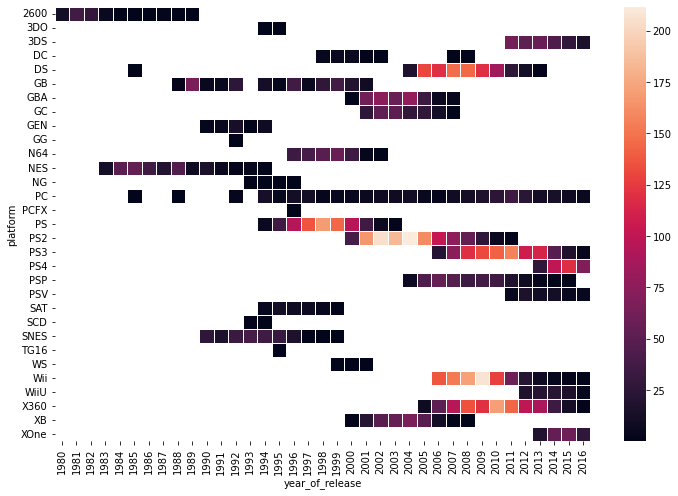

In [92]:
plt.figure(figsize = (12,8))
sb.heatmap(sales_by_platform_pivot, linewidths=.5);

<pre>
Старые платформы просуществовали около 10 лет, такие как 2600 и NES
Переход платформу нового поколения заниммает от 2 до 4 лет: GB > GBA 2 года, PS > PS2 4 года, PS2 > PS3 6 лет.
Игры на консолях самые прибыльные: PS/PS2/PS3, X360, Wii, DS
</pre>

In [94]:
# sales_by_platform.query('platform == "PS4"')\
#     .plot(kind='scatter', x='year_of_release', y='all_sales', figsize=(9,6), legend=True, grid=True);

### Данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год
Не учитывайте в работе данные за предыдущие годы

<pre>
Выберем для дальнейшего анализа период начала все еще актуальных платвфор, в игры, которох играют по настоящий момент.
2013 - 2016 гг.
</pre>

In [95]:
sales_by_platform_from2013 = sales_by_platform.query('year_of_release >= 2013')

### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ

In [ ]:
# Выведим лидер по продажам за последние 3 года
sales_by_platform_from2013.sort_values(by='all_sales', ascending=False).head(15)['platform'].unique()

array(['PS4', 'PS3', 'X360', 'XOne', '3DS', 'WiiU'], dtype=object)

In [ ]:
# Платформы с низкими продажами
sales_by_platform_from2013.sort_values(by='all_sales').head(15)['platform'].unique()

array(['PSP', 'Wii', 'X360', 'DS', 'PS3', 'PSV', 'WiiU', 'PC'],
      dtype=object)

In [ ]:
px.line(sales_by_platform_from2013, 
        x="year_of_release", 
        y='all_sales', 
        color='platform', 
        title='Life expectancy in Canada')

In [96]:
sales_by_platform_from2013.plot.line(column='all_sales', by="platform", x='year_of_release', figsize=(16, 18), grid=True);

TypeError: line() got an unexpected keyword argument 'column'

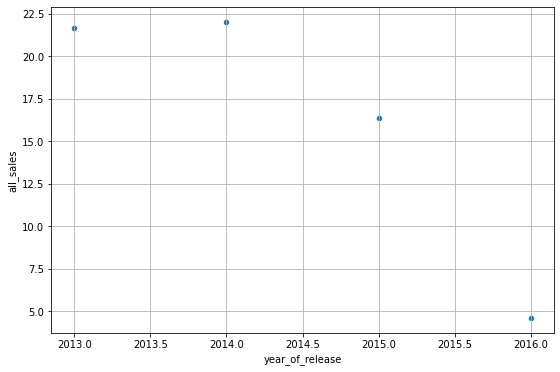

In [ ]:
sales_by_platform_from2013.query('platform == "WiiU"')\
    .plot(kind='scatter', x='year_of_release', y='all_sales', figsize=(9,6), legend=True, grid=True);

# wiiu, ps3, PSV идет на спад

### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат

In [ ]:
px.box(sales_by_platform_from2013, 
        x="platform", 
        y="all_sales")

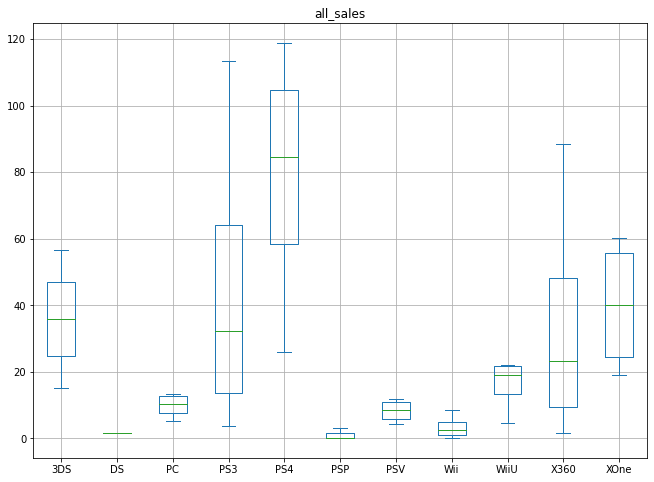

In [ ]:
sales_by_platform_from2013.plot.box(column="all_sales", by="platform", figsize=(11, 8), grid=True);

In [ ]:
good_data_2013 = good_data.query('year_of_release >= 2013')

In [ ]:
game_titles = good_data_2013['name'].unique()

len(game_titles)

1263

In [ ]:
platforms_2013 = good_data_2013['platform'].unique()

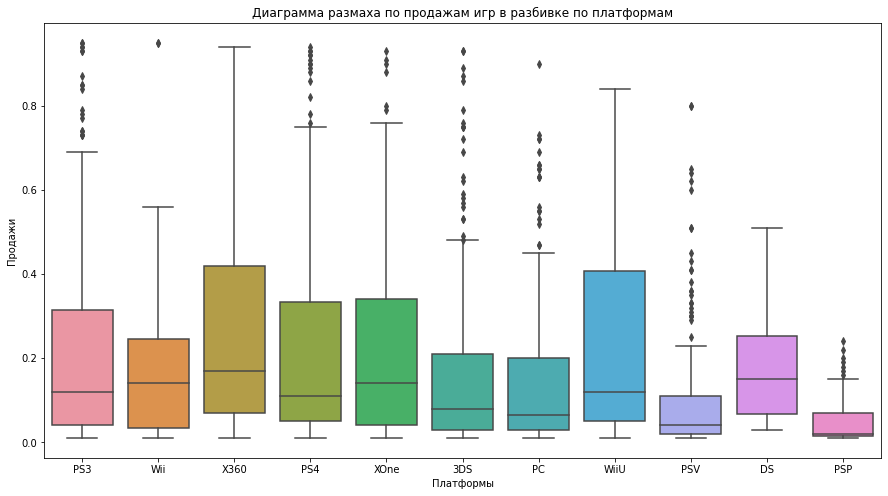

In [ ]:
q1 = good_data_2013['all_sales'].describe()['25%']
q3 = good_data_2013['all_sales'].describe()['75%']
iqr = q3 - q1
low_lim = q1 - 1.5 * iqr
up_lim = q3 + 1.5 * iqr
plt.figure(figsize=(15,8))
sb.boxplot(data=good_data_2013.query('@low_lim < all_sales < @up_lim'), x='platform', y='all_sales')
plt.title('Диаграмма размаха по продажам игр в разбивке по платформам')
plt.xlabel('Платформы')
plt.ylabel('Продажи');

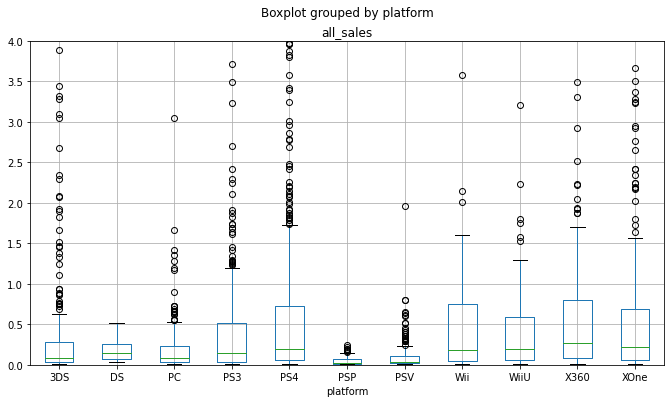

In [ ]:
good_data_2013.boxplot(column='all_sales', by='platform', figsize=(11, 6))
plt.ylim(0,4);

<AxesSubplot:title={'center':'all_sales'}, xlabel='platform'>

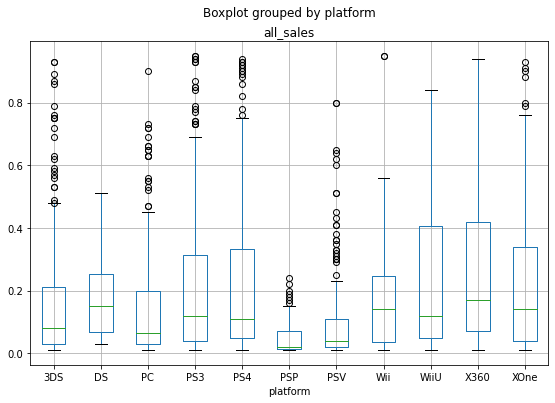

In [ ]:
q1 = good_data_2013['all_sales'].describe()['25%']
q3 = good_data_2013['all_sales'].describe()['75%']
iqr = q3 - q1
low_lim = q1 - 1.5 * iqr
up_lim = q3 + 1.5 * iqr
good_data_2013.query('@low_lim < all_sales < @up_lim').boxplot(column='all_sales', by='platform', figsize=(9, 6))

In [ ]:
# for title in platforms_2013:
#     good_data_2013.query('platform == @title').boxplot(column='all_sales', by='platform', figsize=(9, 6))

In [ ]:
# for title in platforms_2013:
#     good_data_2013.query('platform == @title').plot.box(x='platform', y='all_sales')

<pre>
Лидеры по продажам - XOne (средняя прибыль больше 40) и PS4 (средняя прибыль больше 80).
На втором месте по продажам 3DS и PS3, больше 30.
Средняя прибыль X360 яуть превышает 20.
Остальные меньше 20.
У PS3 и X360 видно что прадажи идут на спад, Q3 длиннее Q1
</pre>

In [ ]:
# sales_by_platform_from2013[['platform', 'all_sales']].groupby('platform')\
#     .plot(kind="box", figsize=(9,6), legend=True, xlabel='platform');

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы

In [ ]:
# Сделаем отдельный датасет для анализа по PS4
ps4_2013 = good_data.query('platform == "PS4" and year_of_release >= 2013')
ps4_2013.sample(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
4770,Tales of Zestiria,PS4,2015,Role-Playing,0.17,0.15,0.02,0.06,72.0,6.8,T,0.40
12228,Terraria,PS4,2014,Action,0.00,0.05,0.01,0.01,83.0,7.9,T,0.07
4879,Saints Row IV,PS4,2015,Action,0.13,0.18,0.03,0.06,NaN,NaN,unrated,0.40


In [ ]:
round(ps4_2013[['critic_score', 'user_score', 'all_sales']].corr()*100)

,critic_score,user_score,all_sales
critic_score,100.0,56.0,41.0
user_score,56.0,100.0,-3.0
all_sales,41.0,-3.0,100.0


#### Зависимость продаж от user_score

In [ ]:
px.scatter(ps4_2013, 
            x="all_sales", 
            y="user_score",
            color='all_sales')

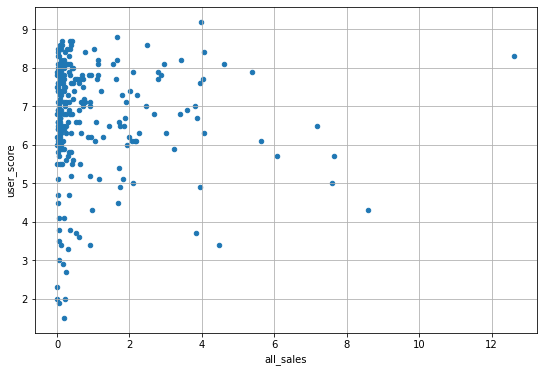

In [ ]:
ps4_2013.plot(kind='scatter', x='all_sales', y='user_score', figsize=(9,6), grid=True);

<pre>
Как ни странн, но на плейстейшн пользовательские оценки сильного влияния на продажи не имеют.
Зависимость = 3%
</pre>

#### Зависимость продаж от critic_score

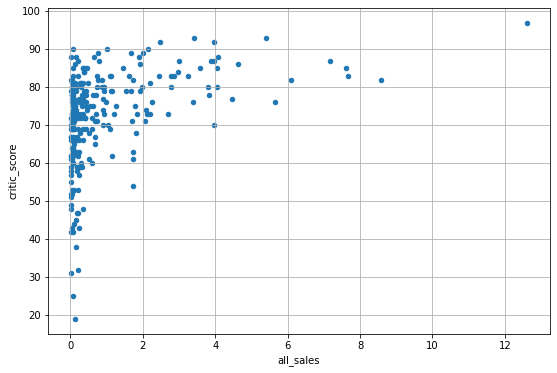

In [ ]:
ps4_2013.plot(kind='scatter', x='all_sales', y='critic_score', figsize=(9,6), grid=True);

<pre>
Большее влиянеие для продаж на плейстейшн имеют оценки критиков.
Корреляция = 41%
</pre>

### Соотнесите выводы с продажами игр на других платформах

In [ ]:
# Сравним с другими платформами за этот же период.
good_data_2013 = good_data.query('year_of_release >= 2013 and user_score > 0')
corr_by_platform_2013 = good_data_2013[['platform', 'critic_score', 'user_score', 'all_sales']].groupby('platform').corr()*100
corr_by_platform_2013 = round(corr_by_platform_2013)
corr_by_platform_2013.style.background_gradient()

In [ ]:
px.scatter(good_data_2013, 
            x="all_sales", 
            y="critic_score",
            color='platform',
            hover_data=['name', 'user_score'])

In [ ]:
px.scatter(good_data_2013, 
            x="all_sales", 
            y="user_score",
            color='platform',
            hover_data=['name'])

In [ ]:
# for title in platforms_2013:
#     good_data_2013.query('platform == @title').plot(kind='scatter', x='all_sales', y='critic_score', figsize=(9,6), grid=True, title=title);


<pre>
Исключим платформы по которым не достаточн данных для анализа: DS.
B частично по оценкам критиков.
На других платформах пользовательские оценки влияют на продажи: 
    3DS - 24%, 
    Wii - 68%,
    WiiU - 42%.
На крупных консолях (PS и xone) пользовательские оценки не имеют значения.
На ПК пользовательские оценки, как оказалось, тоже мало влияют -9%.
Оценки критиков важнее, но не превышают 50%

</pre>

### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [ ]:
# Проверим зависимость прибыли от жанров в тот же период, т.е. 2013 -2016
sales_by_genre = good_data_2013.groupby('genre').agg({'all_sales':'sum'}).reset_index()
sales_by_genre.sort_values(by='all_sales', ascending=False).style.background_gradient()

,genre,all_sales
0,Action,256.830000
8,Shooter,189.960000
10,Sports,144.910000
7,Role-Playing,64.190000
4,Platform,35.430000
6,Racing,35.190000
3,Misc,26.930000
2,Fighting,19.010000
9,Simulation,12.260000
1,Adventure,11.530000


<pre>
Самые прибыльные с 2013 года являются жанры:
    action 257 млн (явный лидер по продажам),
    shooter 190 млн,
    sports 145 млн,
    role-playing 64 млн.

Самые не прибыльные оказались стратегии (8 млн продаж) и пазлы (2 млн продаж).
</pre>

## Определиние для пользователя каждого региона (NA, EU, JP):

### Самые популярные платформы (топ-5). Опишите различия в долях продаж.

In [ ]:
# Рассматривать будем все за тот же 2013 период
# Топ 5 платформ в Северной Америке
top5_in_na = good_data_2013.groupby('platform').agg({'na_sales':'sum'}).reset_index()\
    .sort_values(by='na_sales', ascending=False)\
        .head(5)

In [ ]:
px.pie(top5_in_na, 
        values='na_sales', 
        names='platform')

In [ ]:
# Топ 5 платформ в Европе
good_data_2013.groupby('platform').agg({'eu_sales':'sum'}).reset_index()\
    .sort_values(by='eu_sales', ascending=False)\
        .head(5)

,platform,eu_sales
4,PS4,112.78
3,PS3,59.19
10,XOne,43.34
9,X360,36.19
2,PC,22.16


In [ ]:
# Топ 5 платформ в Японии
good_data_2013.groupby('platform').agg({'jp_sales':'sum'}).reset_index()\
    .sort_values(by='jp_sales', ascending=False)\
        .head(5)

,platform,jp_sales
3,PS3,14.32
0,3DS,14.25
4,PS4,9.45
8,WiiU,8.36
6,PSV,6.61


<pre>
В Северной Америки популярны консоли.
    Лидирует PS4, xone на втором месте. WiiU на пятом месте.
    Продажи не сильно различаются У плейстейшн и Иксбокс, 85 и 79 млн соотвественно.

В Европе предпочитают консоли плейстейшн и иксбокс, на пятом песте ПК.
    Плейстейшн продается в Европе лучше всех: 113 млн.

В Японии лидирует плейстешн 3,
    Пк нет совсем. только приставки.
    На втором месте 3DS
    Продажи, на удивление, в Японии ниже чем в Америке и Европе. 
    Максимум 14 млн.

    
</pre>

### Самые популярные жанры (топ-5). Поясните разницу.

In [ ]:

def top_5(regions: list, category: str) -> list:
    top_5 = []
    for region in regions:
        top_5.append(good_data_2013.groupby(category).agg({region:'sum'}).reset_index()\
            .sort_values(by=region, ascending=False)\
                .head(5))
    return top_5

regions = ['na_sales', 'eu_sales', 'jp_sales']


print('Северная Америка \n', top_5(regions, 'genre')[0])
print('Европа \n', top_5(regions, 'genre')[1])
print('Япония \n', top_5(regions, 'genre')[2])

Северная Америка 
            genre  na_sales
0         Action    108.43
8        Shooter     90.15
10        Sports     64.14
7   Role-Playing     24.02
4       Platform     15.53
Европа 
            genre  eu_sales
0         Action    100.49
8        Shooter     71.00
10        Sports     59.38
7   Role-Playing     19.82
6         Racing     17.46
Япония 
           genre  jp_sales
0        Action     16.13
7  Role-Playing     13.68
8       Shooter      5.79
4      Platform      4.17
3          Misc      3.12


In [ ]:
for i in range(len(regions)):
        px.pie(top_5(regions, 'genre')[i],
                values=regions[i], 
                names='genre').show()

<pre>
По жанрам Северная Америка и Европа похожи, различия в количестве продаж.
В Японии на первом месте жанр action, на втором ролевые игры. 
На третьем шутеры.
В Я понии ролевые игры любят больше.

</pre>

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [ ]:
print('Северная Америка \n', top_5(regions, 'rating')[0])
print('Европа \n', top_5(regions, 'rating')[1])
print('Япония \n', top_5(regions, 'rating')[2])

Северная Америка 
     rating  na_sales
2        M    164.64
0        E     78.24
1     E10+     51.97
3        T     49.60
4  unrated      1.63
Европа 
     rating  eu_sales
2        M    144.32
0        E     81.98
3        T     41.78
1     E10+     39.98
4  unrated      2.71
Япония 
     rating  jp_sales
3        T     18.80
0        E     14.81
2        M     14.05
1     E10+      5.76
4  unrated      0.44


<pre>
В Америке и в Евроме лучше всего продаются взрослые игры. 
В то время как в Японии лидируют подростковые.
Игры для детей занимают 5 место.
Игры для всех на втором месте.
</pre>

## Проверка гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

```
H_0: пользовательские рейтинги (user_score) для платформы xbox = (user_score) для ПК.
H_a: Пользовательский рейтинг (user_score) платформы "xbox" ≠ пользовательскому рейтингу (user_score) для ПК.
alpha = 0.05
```

In [ ]:
user_score_xone = good_data_2013.query('platform == "XOne"')['user_score']

In [ ]:
user_score_pc = good_data_2013.query('platform == "PC"')['user_score']

In [ ]:
user_score_pc.unique()

array([3.9, 7.9, 2.2, 6. , 5.4, 5.7, 5.9, 4.2, 9.3, 8.5, 8. , 7.7, 5.5,
       6.7, 6.5, 6.2, 3. , 6.8, 8.3, 8.2, 4.7, 5.8, 4.5, 4.6, 7.6, 6.9,
       2.1, 7.5, 3.3, 7.3, 7.1, 4.4, 3.2, 8.6, 4.3, 7.4, 3.5, 8.1, 4.8,
       6.4, 8.4, 5.3, 8.9, 3.8, 2.5, 7. , 2.9, 3.6, 5.1, 3.4, 4. , 6.1,
       6.3, 8.7, 7.8, 1.4, 3.7, 2.4])

In [ ]:
results = st.ttest_ind(
    user_score_xone, 
    user_score_pc, 
    equal_var=False)

alpha = 0.05 # значение уровня значимости

# вывод значения p-value на экран 
# условный оператор с выводом строки с ответом


print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

```
H_0: пользовательские рейтинги (user_score) для жанра action = (user_score) для жанра спорт.
H_a: Пользовательский рейтинг (user_score) для жанра action ≠ пользовательскому рейтингу (user_score) для жанра спорт.
alpha = 0.05
```

In [ ]:
user_score_action = good_data_2013.query('genre == "Action"')['user_score']

In [ ]:
user_score_sport = good_data_2013.query('genre == "Sports"')['user_score']

In [ ]:
results = st.ttest_ind(
    user_score_action, 
    user_score_sport, 
    equal_var=False)

alpha = 0.05 # значение уровня значимости

# вывод значения p-value на экран 
# условный оператор с выводом строки с ответом


print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

1.4460039700704318e-20
Отвергаем нулевую гипотезу


## Conclusion

<div style='
    border-radius: 21px; 
    padding: 8px;
    max-width: 70%;
    resize: both;
    overflow: auto;
    background-color: gray;
    color: white;
    font: 1em bold "Courier New", monospace;
    margin: 20px auto;
    padding: 17px;
    letter-spacing: 3px;'>
<pre>
Кличество игр за весь период и статистика роста и спада.
    Анализ данных за период 1980 по 2016 год.
    С 1992 года количество игр начало резко увеличиваться. 
    Пик приходится на 2008 и 2009 годы, 1427 и 1426 игр соответственно.
    после 2009 года начинается спад выпускаемых игр.
    Рассмотрели все периоды, так как чем больше данных тем качественне статистика по ним.
    Видно что 1983 по 1990 период стабильности по выпускаемому количеству игр, резких спадов или ростов нет.
    После этого идет резкий рост и резкий спад.


Гипотеза зависимости продаж от цикл жизни платформ.
    Старые платформы просуществовали около 10 лет, такие как 2600 и NES
    Переход платформу нового поколения заниммает от 2 до 4 лет: GB > GBA 2 года, PS > PS2 4 года, PS2 > PS3 6 лет.
    Игры на консолях самые прибыльные: PS/PS2/PS3, X360, Wii, DS
    Актуальные платформы - новые версии консолей(PS4), новые приставки и ПК.

    Самые продаваемые игры на платформах.
        Лидеры по продажам - XOne (средняя прибыль больше 40) и PS4 (средняя прибыль больше 80).
        На втором месте по продажам 3DS и PS3, больше 30.
        Средняя прибыль X360 яуть превышает 20.
        Остальные меньше 20.
        У PS3 и X360 видно что прадажи идут на спад, Q3 длиннее Q1
    
    Гипотиза подтвердилась, для каждой платформы есть росс, пик и спад продаж. Особенно актуально для консолей.
    С выходом новой версии консоли пик продаж переходит на них.
    Исключение составляет ПК, для него обновляется только железо, оэто там продажи постоянно есть.



Выберем для дальнейшего анализа период начала все еще актуальных платвфор, в игры, которох играют по настоящий момент.
2013 - 2016 гг.


Гипотеза зависимости продаж от пользовательских оценок и оценок критиков.
    Исключим платформы по которым не достаточн данных для анализа: DS.
    И частично по оценкам критиков.
    Платформы, где оценки влияют на продажи: 
        3DS - 24%, 
        Wii - 68%,
        WiiU - 42%.
    На крупных консолях (PS и xone) пользовательские оценки не имеют значения.
    На ПК пользовательские оценки, как оказалось, тоже мало влияют -9%.
    Оценки критиков важнее, но не превышают 50%

    Гипотиза частично подтвердилась. Оценки действительно влияют на продажи, но есть зависимость от платформы.
    Для всех платформ есть зависимость от оценок критиков.
    Но не для всех консолей, есть зависимость от пользовательских оценок.


Гипотиза зависимости продаж от жанра игры.
    Самые прибыльные с 2013 года являются жанры:
        action 257 млн (явный лидер по продажам),
        shooter 190 млн,
        sports 145 млн,
        role-playing 64 млн.
    
    Самые не прибыльные оказались стратегии (8 млн продаж) и пазлы (2 млн продаж).

    Гипотиза подтвердилась: некоторые жанры действительно намного популярнее других.


Гипотиза предпочтения пользователей в зависимости от страны.
    Различия по платформам:
        В Северной Америки популярны консоли.
            Лидирует PS4, xone на втором месте. WiiU на пятом месте.
            Продажи не сильно различаются У плейстейшн и Иксбокс, 85 и 79 млн соотвественно.
        
        В Европе предпочитают консоли плейстейшн и иксбокс, на пятом песте ПК.
            Плейстейшн продается в Европе лучше всех: 113 млн.
        
        В Японии лидирует плейстешн 3,
            Пк нет совсем. только приставки.
            На втором месте 3DS
            Продажи, на удивление, в Японии ниже чем в Америке и Европе. 
            Максимум 14 млн.

    Различия по жанрам:
        По жанрам Северная Америка и Европа похожи, различия в количестве продаж.
        В Японии на первом месте жанр action, на втором ролевые игры. 
        На третьем шутеры.
        В Я понии ролевые игры любят больше.
    
    Различия по рейтингу:
        В Америке и в Евроме лучше всего продаются взрослые игры. 
        В то время как в Японии лидируют подростковые.
        Игры для детей занимают 5 место.
        Игры для всех на втором месте.

    Гипотиза частично подтвердилась: Для Америки и Европы различия не такие большие, 
    а вот у пользователей из Японии уже сильно прослеживаются другие предпочтения, 
    чем у пользователей из Европы и Америки. 
    Поэтому надо учитывать эти заличия при продвижении игр.


Гипотеза Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
    0.14759594013430463
    Не получилось отвергнуть нулевую гипотезу

Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные
    1.4460039700704318e-20
    Отвергаем нулевую гипотезу
</pre></div>